In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


#### Normalized Laplacian of Gaussian (NLOG) Operator in 1D and Blob detection

In [74]:
def LOG_filter(sigma=1.0, normalize=False):
    # set the filter size proportional to sigma
    kernel_size = int(2 * np.ceil(3*sigma) + 1)
    # construct a 2d gaussian jernel by taking outer product of 2 1d gaussian kernels
    gaussian_1d = cv2.getGaussianKernel(kernel_size, sigma)
    # compute outer product of the two 1d kernels to get the 2d gaussian kernels
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    # apply laplacian operator to get LOG filter
    LOG_filter = cv2.Laplacian(gaussian_2d, cv2.CV_64F)
    
    if normalize:
        LOG_filter = sigma * sigma * LOG_filter
    
    return LOG_filter 

In [65]:
def blur(img, sigma=1.0):
    # first convolve the image with a gaussian
    # Note: set kernel size parameter to zero so that the size is internally computed from sigma
    img_blurred = cv2.GaussianBlur(img, (0,0), sigma)

    return img_blurred


def NLOG(img, sigma=1.0):
    # first convolve the image with a gaussian
    # Note: set kernel size parameter to zero so that the size is internally computed from sigma
    img_blurred = cv2.GaussianBlur(img, (0,0), sigma)
    # now apply the laplacian operator and normalize by multiplying with sigma squared
    img_NLOG =  sigma * sigma * cv2.Laplacian(img_blurred, cv2.CV_64F)

    return img_NLOG


#### Now load a test imagve and convolve with the NLOG kernel

(903, 905)


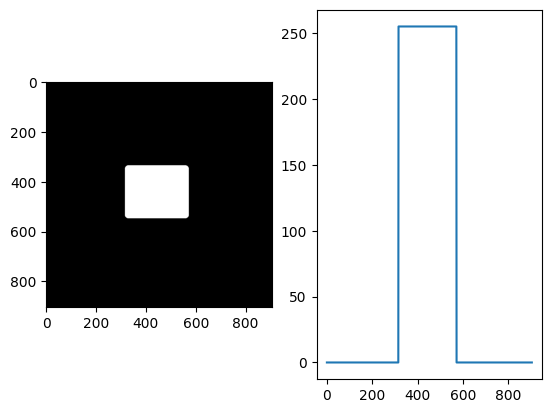

In [91]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img = np.array(cv2.imread("./square1.png", cv2.IMREAD_GRAYSCALE)).astype('float32')
print(img.shape)

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
#plt.axis('off')

plt.subplot(1,2,2)
plt.plot(img[450,:])
plt.show()


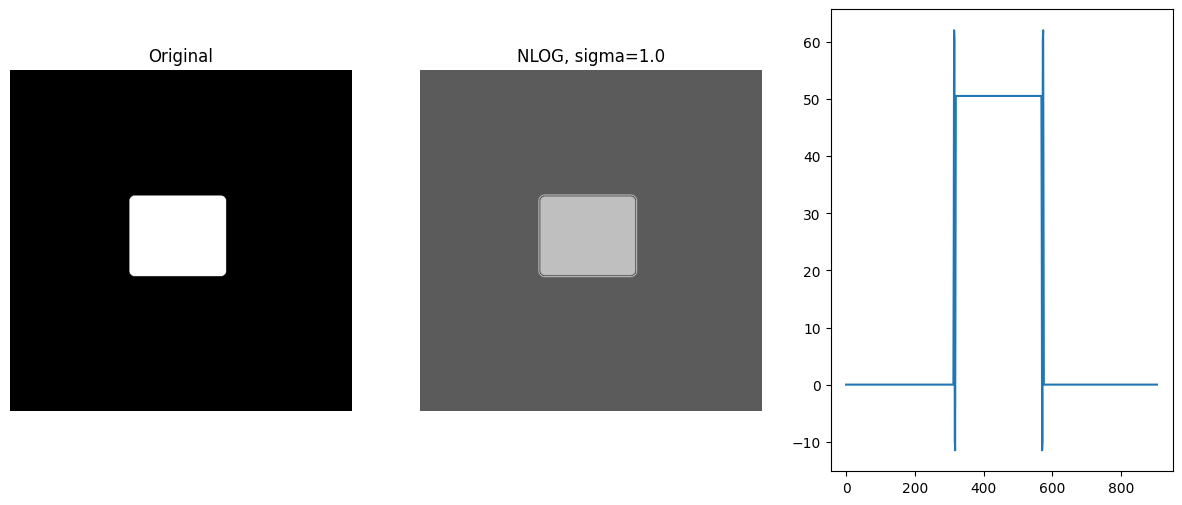

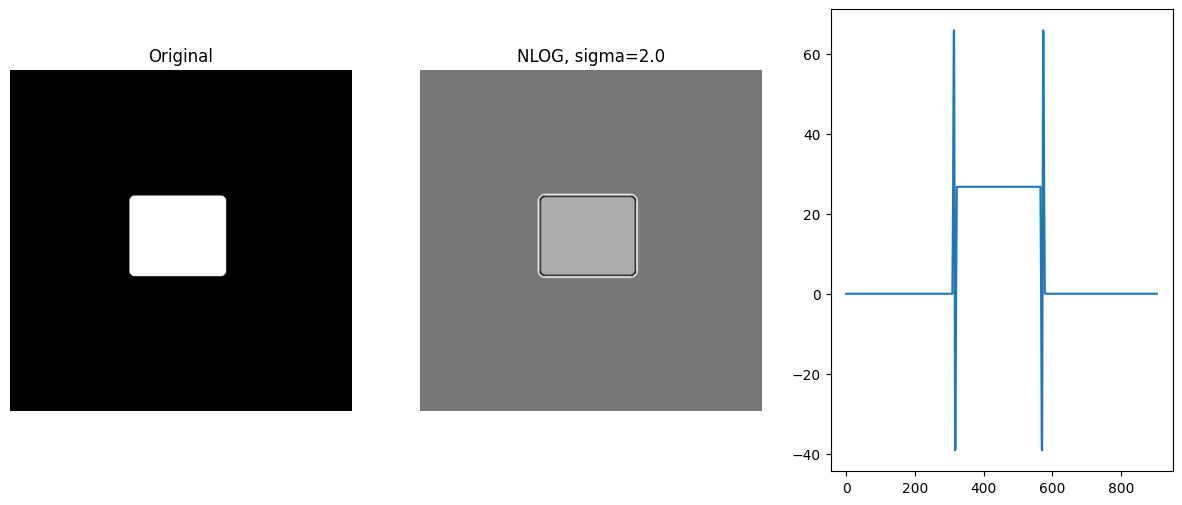

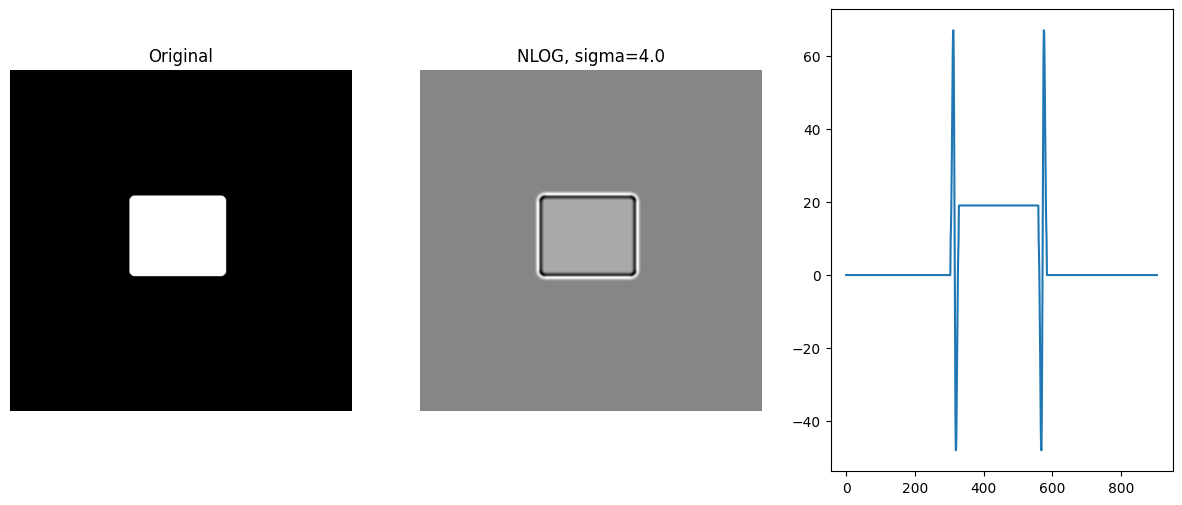

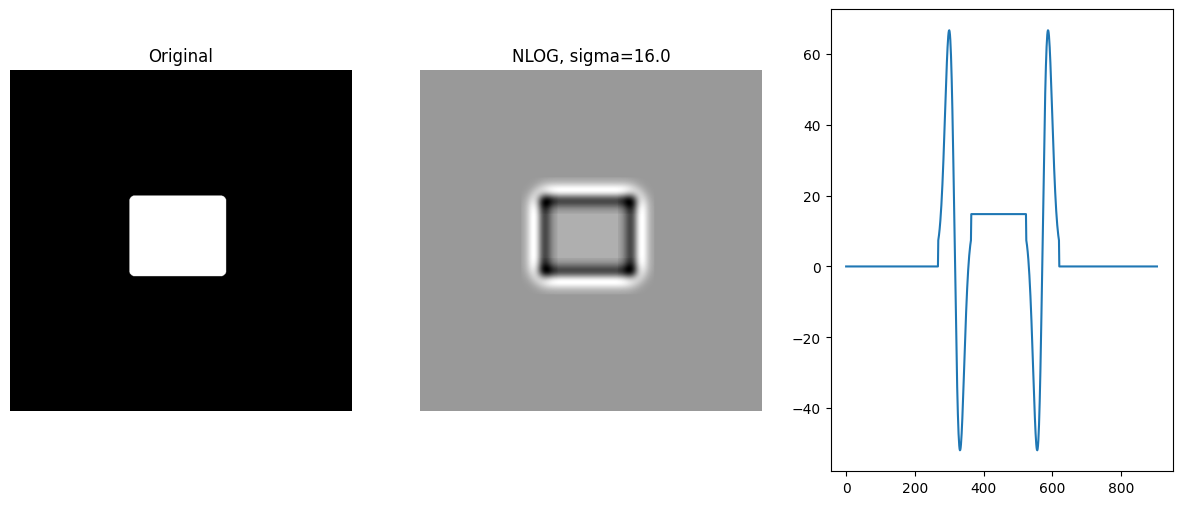

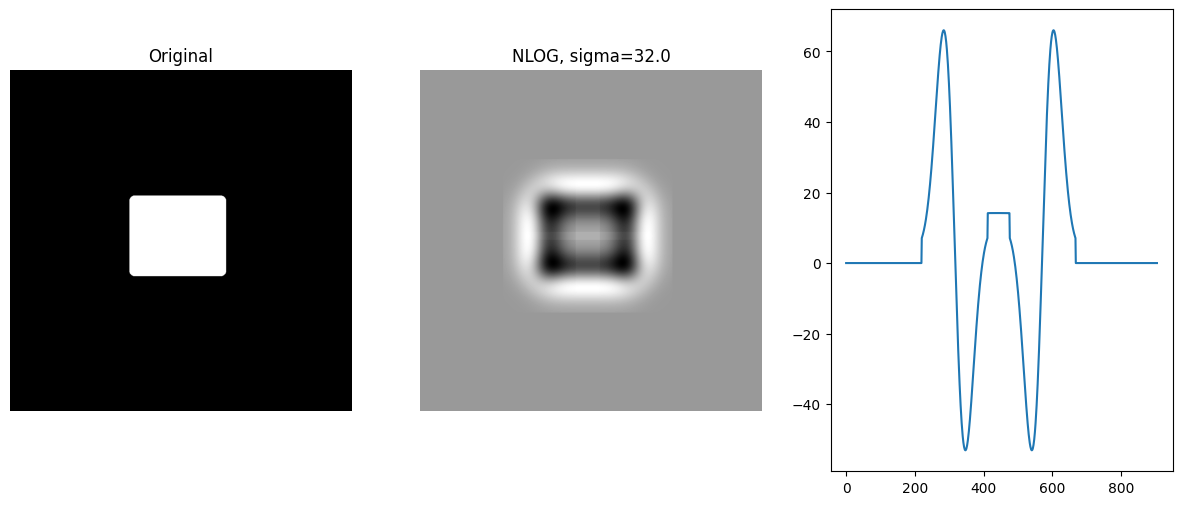

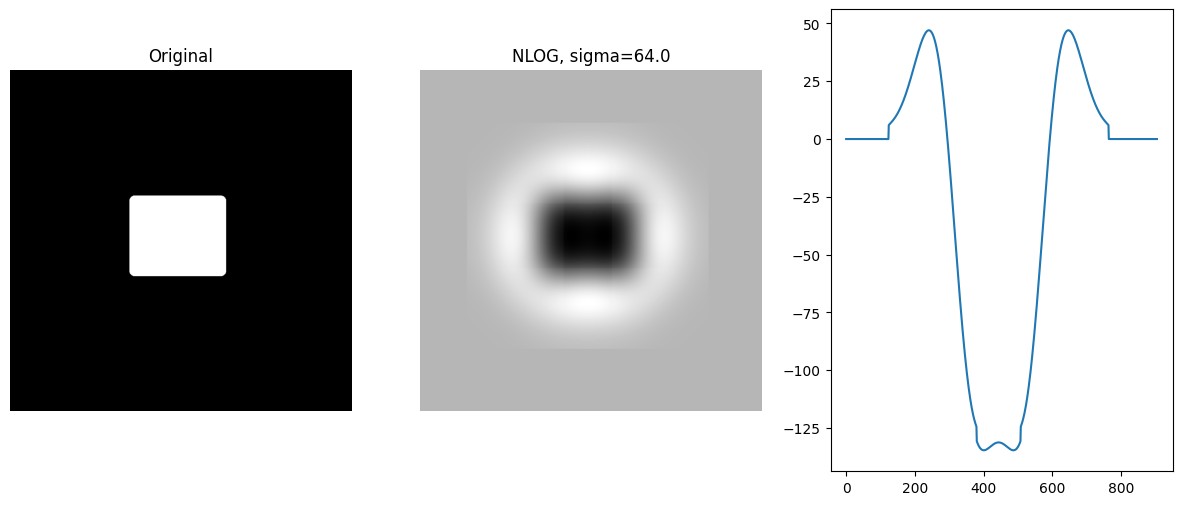

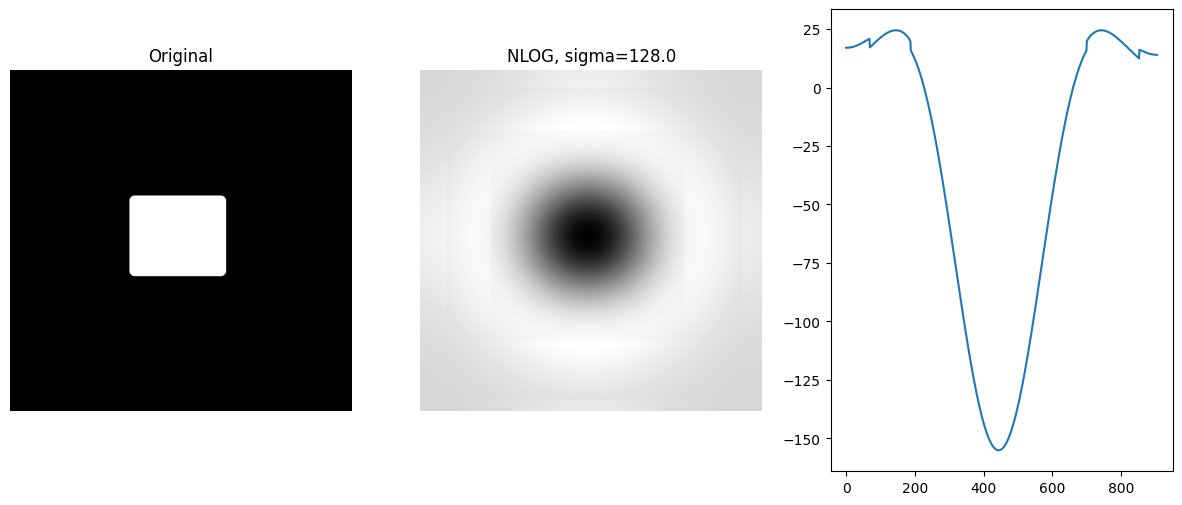

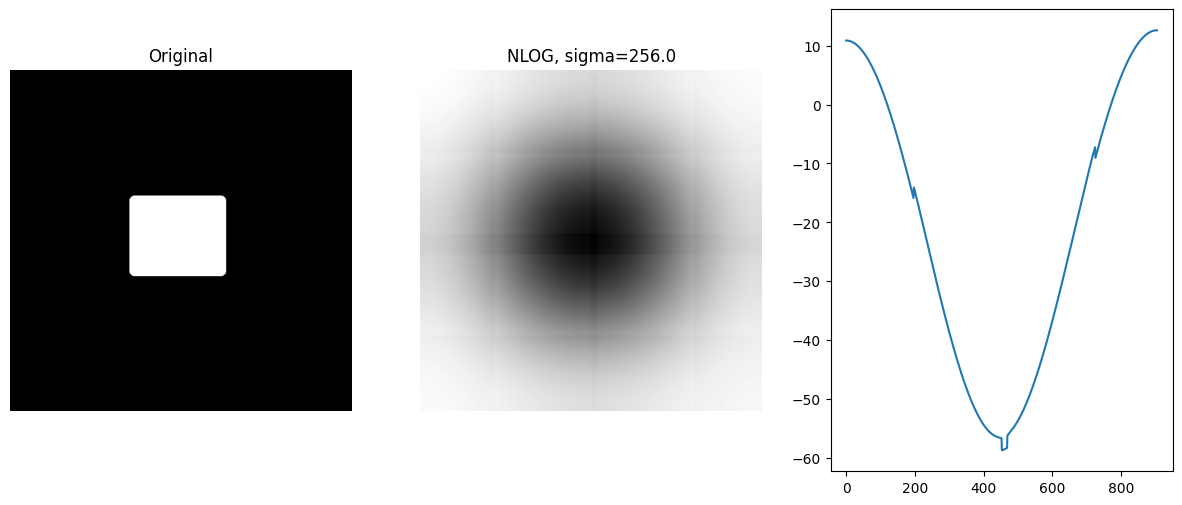

In [92]:
# apply NLOG to the image with different sigma values
sigmas = [1.0, 2.0, 4.0, 16.0, 32.0, 64.0, 128.0, 256.0]

for sigma in sigmas:

    filter = LOG_filter(sigma=sigma, normalize=True)
    img_log =  cv2.filter2D(img, -1, filter, cv2.CV_64F)

    plt.figure(figsize=(15,6))

    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(img_log, cmap='gray')
    plt.title('NLOG, sigma='+str(sigma))
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.plot(img_log[450,:])
    plt.show()



